<br><br>
<font size='6'><b>Layer-wise Relevance Propagation (LRP)
</b></font><br><br>

<br>
<div class=pull-right>
By Prof. Hyunseok Oh<br>
https://sddo.gist.ac.kr/<br>
SDDO Lab at GIST
</div>

Table of Contents
* [1. Why we need XAI?](#section1)
* [2. Making Deep Neural Nets Transparent](#section2)
* [3. Layer-wise Relevance Propagation (LRP)](#section3)
* [4. LRP with Tensorflow](#section4)
* [5. Result Examples](#section5)
* [6. Further Study Resources](#section6)

Reference for this contents
- https://github.com/atulshanbhag/Layerwise-Relevance-Propagation

<a name = 'section1'></a>

# 1. Why we need XAI?

- Deep learning is a 'black-box' model that cannot be interpreted by users.
- We need to figure out "why" does the model arrive at a certain prediction.

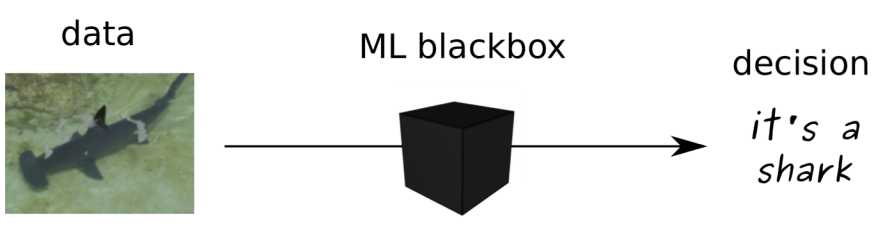

<a name = 'section2'></a>

# 2. Making Deep Neural Nets Transparent

- Interpreting models: how to interpret the model itself
- Explaining decisions: how to figure out why the decision was made.

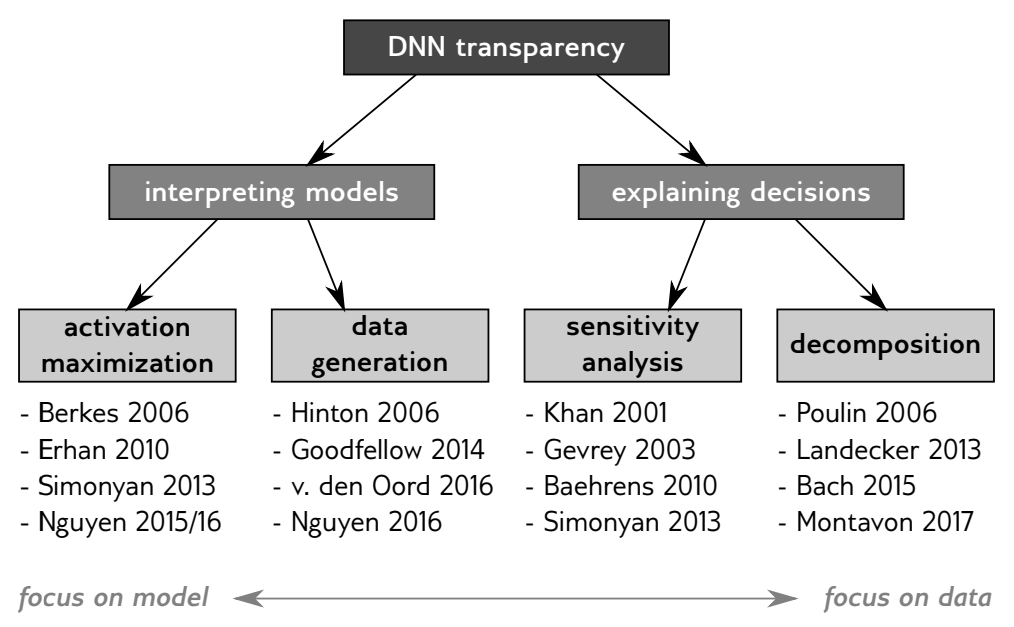

<a name = 'section3'></a>

# 3. Layer-wise Relevance Propagation (LRP)

- LRP is a technique that describes the decision boundary of model by applying Taylor decomposition.
- As its name implies, the relevance $R(x)$ that contributed to the prediction results is calculated and propagated for each layer.
- That is, LRP can check the influence of each pixel of the input layer on the prediction results.

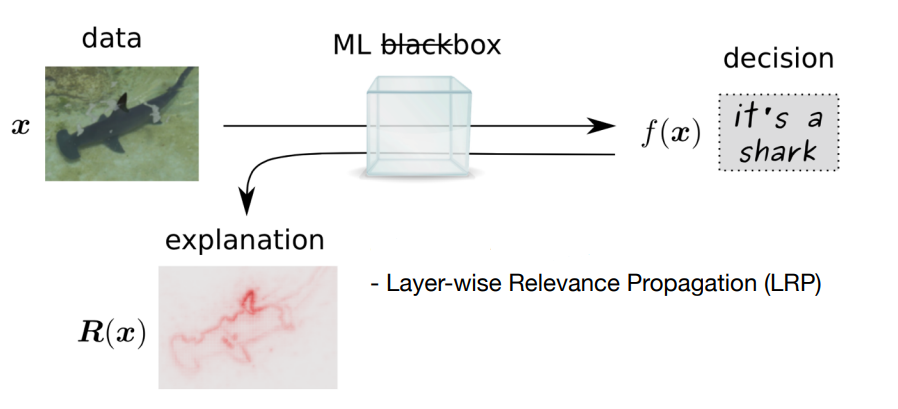

The basic assumptions and how LRP works are as follows:

- Each neuron has a certain relevance.
- The relevance is redistributed from the output to the input of each neuron.
- The relevance is preserved when redistributed to each layer. 

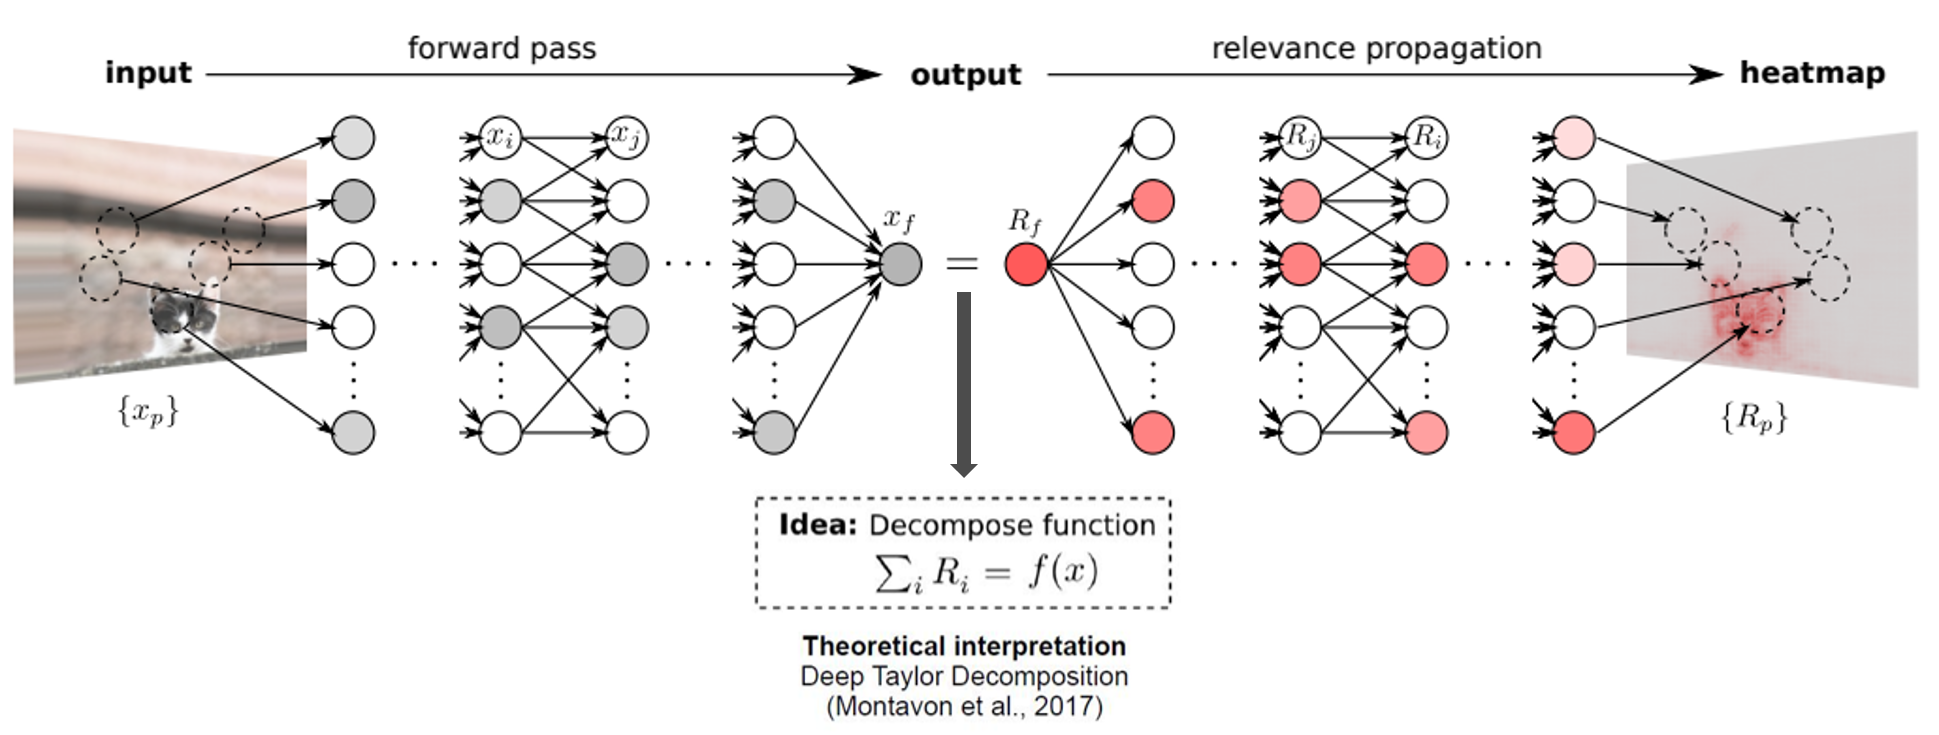

<a name = 'section4'></a>

# 4. LRP with Tensorflow

## 4.1 Import Libary

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.cm                import get_cmap

from tensorflow.keras.preprocessing.image    import img_to_array, load_img
from tensorflow.keras.applications.vgg16     import (preprocess_input, decode_predictions)
from tensorflow.keras                        import backend as K
from tensorflow.python.ops                   import gen_nn_ops
from tensorflow.keras.applications.vgg16     import VGG16

tf.compat.v1.disable_eager_execution()

## 4.2 Load ImageNet Data

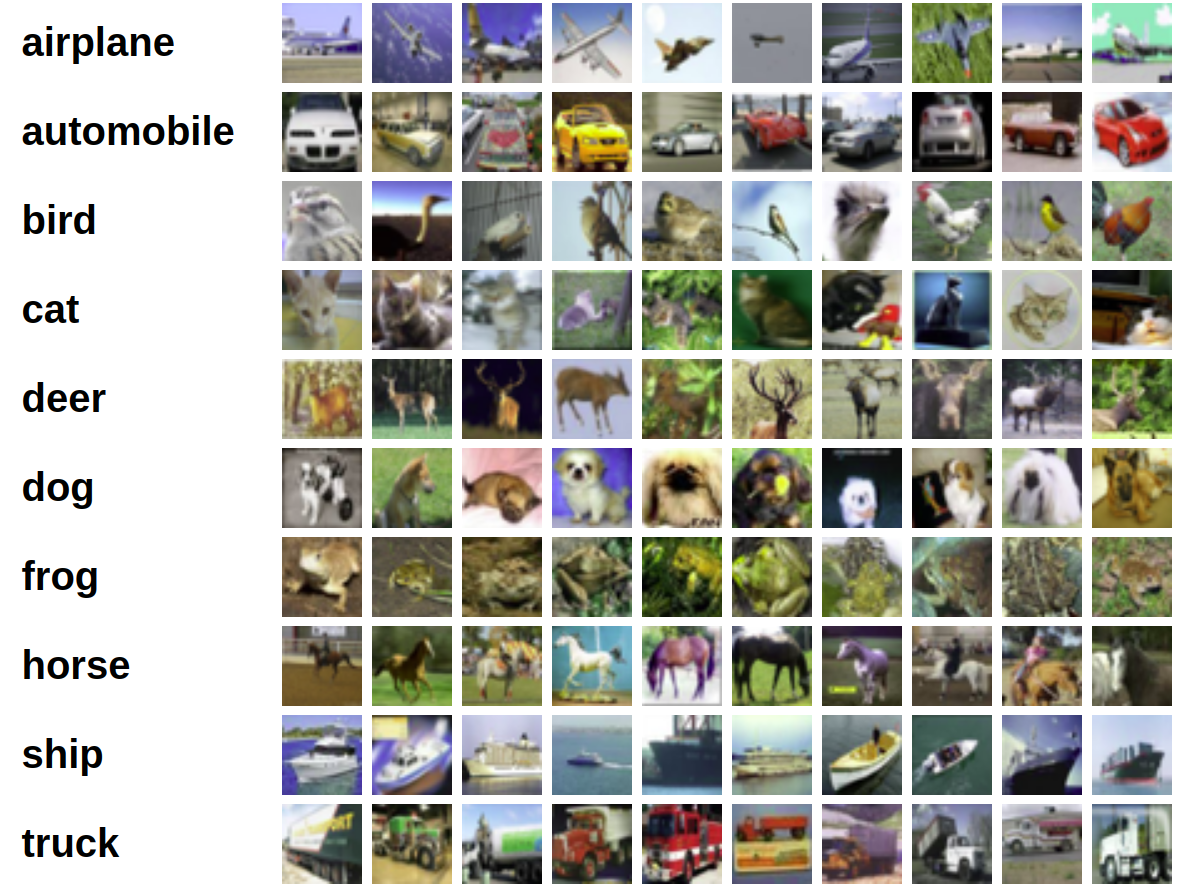

In [ ]:
!wget https://url.kr/argi5c -O 'images.zip'
!unzip images.zip -d './images'

--2022-01-18 06:04:59--  https://url.kr/argi5c
Resolving url.kr (url.kr)... 183.111.169.122
Connecting to url.kr (url.kr)|183.111.169.122|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://url.kr/spam_filtering_system.php?short=argi5c [following]
--2022-01-18 06:05:02--  https://url.kr/spam_filtering_system.php?short=argi5c
Reusing existing connection to url.kr:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MinseokOff/KSME_advanced/raw/main/LRP/images.zip [following]
--2022-01-18 06:05:02--  https://github.com/MinseokOff/KSME_advanced/raw/main/LRP/images.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MinseokOff/KSME_advanced/main/LRP/images.zip [following]
--2022-01-18 06:05:02--  https://raw.githubusercontent.com/MinseokOff/KSME_advanced/main/LR

In [ ]:
# 약 1,400 만개가 넘는 이미지 데이터베이스
# ImageNet 데이터 중 개와 고양이 일부 샘플
# 아래 있는 이미지 목록 중 선택하기

file_list = os.listdir('./images')
file_list = [file for file in file_list if file.endswith(".jpg")]
for i in file_list:
    print(i)

cat.5.jpg
dog.5.jpg
dog.6.jpg
dog.4.jpg
cat.2.jpg
cat.4.jpg
cat.6.jpg
dog.7.jpg
cat.1.jpg
cat.7.jpg
dog.3.jpg
dog.2.jpg
dog.1.jpg
cat.3.jpg
dog.0.jpg


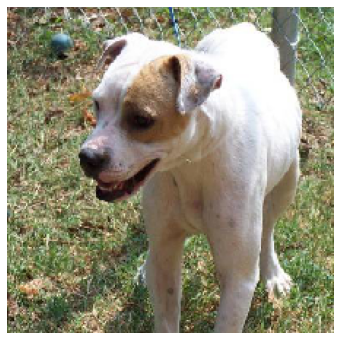

In [ ]:
# LRP에 사용할 이미지 입력
image_ = load_img('./images/dog.0.jpg', target_size=(224, 224))
plt.figure(figsize=(6,6))
plt.imshow(image_)
plt.axis('off')

# 학습에 사용할 이미지를 3차원 배열로 변환 및 전처리하는 코드
# processed_images에는 학습에 사용할 이미지가 들어가게 된다.
image = img_to_array(image_)
image = preprocess_input(image)

processed_images = []
processed_images.append(image)
processed_images = np.array(processed_images)

## 4.3 Load VGG16 Model

- Load pretrained VGG16 model to conduct LRP

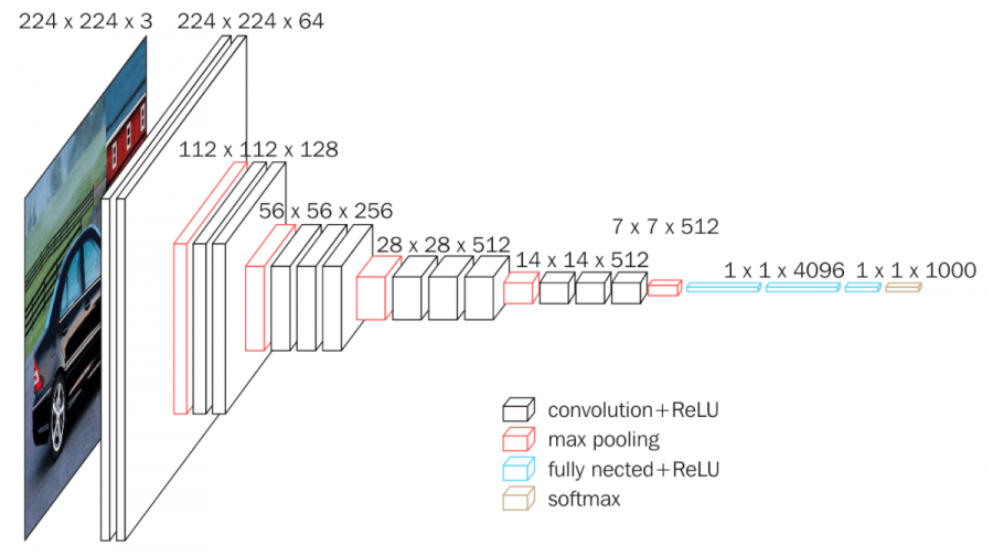

In [ ]:
# Pretrain 된 VGG16의 layer name, activation, weight에 대한 정보를 불러온다.
def get_model_params(model):
    names, activations, weights = [], [], []
    for layer in model.layers:
        name = layer.name if layer.name != 'predictions' else 'fc_out'
        names.append(name)
        activations.append(layer.output)
        weights.append(layer.get_weights())
    return names, activations, weights

# Heatmap을 그리기 위한 함수
def heatmap(image, cmap_type='rainbow', reduce_op='sum', reduce_axis=-1, **kwargs):
    cmap = get_cmap(cmap_type)
    shape = list(image.shape)
    
    # RGB 세 채널의 결과가 계산되므로, 세 채널의 LRP 결과를 모두 합하여 출력한다.
    reduced_image = image.sum(axis=-1)
    
    # LRP 출력 결과를 0~1 사이 범위의 값으로 normalize한다.
    projected_image = project_image(reduced_image, **kwargs)
    heatmap = cmap(projected_image.flatten())[:, :3].T
    heatmap = heatmap.T
    shape[reduce_axis] = 3
    return heatmap.reshape(shape)

# LRP 출력 결과를 normaliize하는 함수
def project_image(image, output_range=(0, 1), absmax=None, input_is_positive_only=False):
    if absmax is None:
        absmax = np.max(np.abs(image), axis=tuple(range(1, len(image.shape))))
    absmax = np.asarray(absmax)
    mask = (absmax != 0)
    if mask.sum() > 0:
        image[mask] /= absmax[mask]
    if not input_is_positive_only:
        image = (image + 1) / 2
    image = image.clip(0, 1)
    projection = output_range[0] + image * (output_range[1] - output_range[0])
    return projection

## 4.4 Tensorflow LRP Implementation Details

Consider the LRP propagation rule of Eq.:
$$
R_j^{(l)} = a_j \sum_k {w^+_{jk} \over \sum_j a_j w^+_{jk} + b^+_k}R^{(l \space + \space 1)}_k
$$

This rule can be decomposed as a sequence of four elementary computations, all of which can also be expressed in vector form:

$\textit{Element-wise}$

$$\begin{align*}
z_k & \leftarrow \epsilon + \sum_j a_j w_{jk}^{+} \\
s_k & \leftarrow R_k \space / \space z_k \\
c_j & \leftarrow \sum_k w_{jk}^{+} s_k \\
R_j & \leftarrow a_j c_j
\end{align*}$$

$\textit{Vector Form}$
$$\begin{align*}
\mathbf{z} & \leftarrow W_{+}^{\top} \cdot \mathbf{a} \\
\mathbf{s} & \leftarrow \mathbf{R} \oslash \mathbf{z} \\
\mathbf{c} & \leftarrow W_{+} \cdot \mathbf{s} \\
\mathbf{R} & \leftarrow \mathbf{a} \odot \mathbf{c}
\end{align*}$$

In [ ]:
class LayerwiseRelevancePropagation:

    def __init__(self, epsilon=1e-7):
        
        self.model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
        self.epsilon = epsilon
        self.names, self.activations, self.weights = get_model_params(self.model)
        self.num_layers = len(self.names)
        self.relevance = self.compute_relevances()
        self.lrp_runner = K.function(inputs=[self.model.input, ], outputs=[self.relevance, ])
        
    # 각 Layer의 relevance를 계산하는 함수
    def compute_relevances(self):
        r = self.model.output
        
        # 반복문을 수행하면서 Relevance score를 Output layer에서 Input layer 방향으로 전파한다.
        for i in range(self.num_layers-2, -1, -1):
            if 'fc' in self.names[i + 1]:
                r = self.backprop_fc(self.weights[i + 1][0], self.weights[i + 1][1], self.activations[i], r)
            elif 'flatten' in self.names[i + 1]:
                r = self.backprop_flatten(self.activations[i], r)
            elif 'pool' in self.names[i + 1]:
                r = self.backprop_max_pool2d(self.activations[i], r)
            elif 'conv' in self.names[i + 1]:
                r = self.backprop_conv2d(self.weights[i + 1][0], self.weights[i + 1][1], self.activations[i], r)
            else:
                raise 'Layer not recognized!'
                sys.exit()
        return r
    
    ############### 각 Layer type에 맞는 Relevance score 계산 함수 #############
    # Fully connected layer의 Relevance를 계산하기 위한 함수
    def backprop_fc(self, w, b, a, r):
        z = K.dot(a, K.constant(w)) + b + self.epsilon
        s = r/z
        c = K.dot(s, K.transpose(w))
        return a*c
    
    # Flatten layer의 Relevance를 넘겨주기 위해 입력 모양을 바꾸는 함수
    def backprop_flatten(self, a, r):
        shape = a.get_shape().as_list()
        shape[0] = -1
        return K.reshape(r, shape)
    
    # Maxpooling layer의 Relevance를 계산하기 위한 함수
    def backprop_max_pool2d(self, a, r, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1)):
        z = K.pool2d(a, pool_size=ksize[1:-1], strides=strides[1:-1], padding='valid', pool_mode='max')+self.epsilon
        s = r/z
        c = gen_nn_ops.max_pool_grad_v2(a, z, s, ksize, strides, padding='VALID')
        return a*c
    
    # Convolution layer의 Relevance를 계산하기 위한 함수
    def backprop_conv2d(self, w, b, a, r, strides=(1, 1, 1, 1)):
        z = K.conv2d(a, kernel=w, strides=strides[1:-1], padding='same') + b + self.epsilon
        s = r/z
        c = tf.compat.v1.nn.conv2d_backprop_input(K.shape(a), w, s, strides, padding='SAME')
        return a*c
    ############################################################################

    # 입력 데이터의 정답을 불러오는 함수    
    def predict_labels(self, images):
        preds = self.model.predict(images)
        decoded_preds = decode_predictions(preds)
        labels = [p[0] for p in decoded_preds]
        return labels
    
    # 아래 함수를 통해 lrp를 계산한다.
    def run_lrp(self, images):
        print("Running LRP on {0} images...".format(len(images)))
        return self.lrp_runner([images, ])[0]
    
    # lrp 결과를 heatmap으로 표현하는 함수
    def compute_heatmaps(self, images, g=0.2, cmap_type='rainbow', **kwargs):
        lrps = self.run_lrp(images)
        print("LRP run successfully...")
        heatmaps = [heatmap(lrp, cmap_type=cmap_type, **kwargs) for lrp in lrps]
        return heatmaps

In [ ]:
# lrp 객체 생성
lrp = LayerwiseRelevancePropagation()

# 입력 데이터의 정답을 불러온다.
labels = lrp.predict_labels(processed_images)
print("Labels predicted...")

# 입력 데이터의 lrp를 계산한 후 heatmap을 그린다.
heatmaps = lrp.compute_heatmaps(processed_images)
print("Heatmaps generated...")

553476096/553467096 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


49152/35363 [=========================================] - 0s 0us/step
Labels predicted...
Running LRP on 1 images...
LRP run successfully...
Heatmaps generated...


## 4.5 Display Images

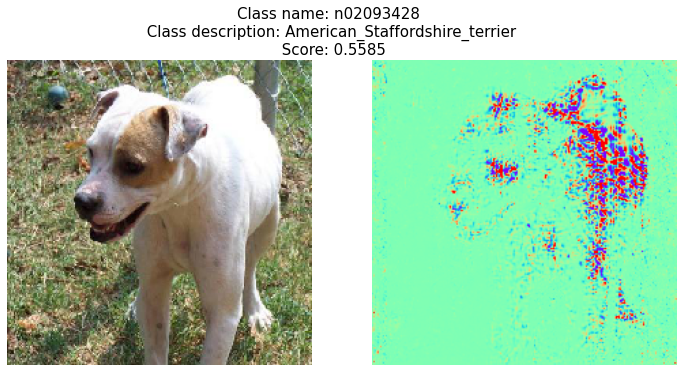

In [ ]:
# lrp 계산 결과 출력
fig = plt.figure(figsize=(12,6))
fig.suptitle("Class name: %s \n Class description: %s \n Score: %.4f" %(labels[0][0], labels[0][1], labels[0][2]),\
             fontsize=15)

ax0 = fig.add_subplot(121)
ax0.axis('off')
ax0.imshow(image_)

ax1 = fig.add_subplot(122)
ax1.axis('off')
ax1.imshow(heatmaps[0], interpolation='bilinear')

plt.show()

<a name = 'section5'></a>

# 5. Result Examples

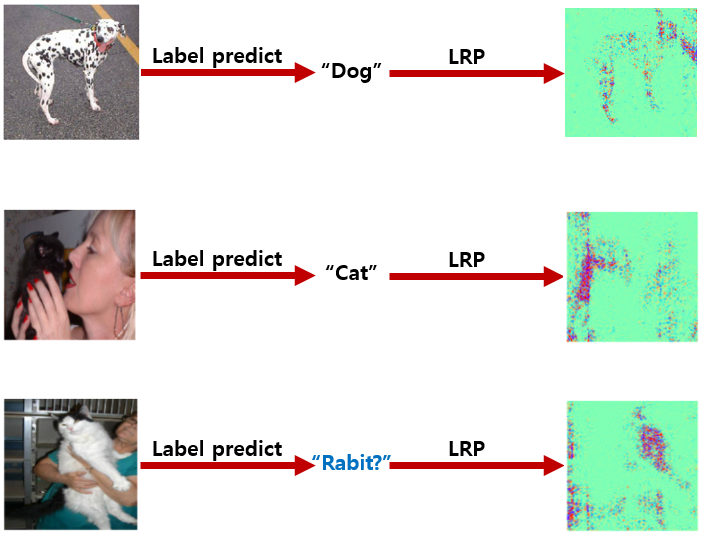

<a name = 'section6'></a>

# 6. APPENDIX

In [ ]:
%%html
<center><iframe src="https://www.youtube.com/embed/BNdb-CcBd0Q" 
width="560" height="315" frameborder="0" allowfullscreen></iframe></center>

In [ ]:
%%html
<center><iframe src="https://www.youtube.com/embed/PDRewtcqmaI?rel=0" 
width="560" height="315" frameborder="0" allowfullscreen></iframe></center>